In [10]:
import tensorflow as tf
from tensorflow.keras import backend
import tensorflow_datasets as tfds

dataset, info = tfds.load("oxford_iiit_pet:3.*.*", with_info=True)

## Transformer for semantic segmentation (Segmenter) 

1. Create conda environment 
2. Install neccessary packages: tensorflow, matplotlib, pynvml 
3. Train Segmenter using custom data

Helpful links: 

[How to train SegFormer](https://keras.io/examples/vision/segformer/) 
[How to fine-tune SegFormer using just one GPU](https://huggingface.co/docs/transformers/perf_train_gpu_one) 
[How to train SegFormer using Custom data

In [11]:
from pynvml import *


def print_gpu_utilization():
    nvmlInit()
    handle = nvmlDeviceGetHandleByIndex(0)
    info = nvmlDeviceGetMemoryInfo(handle)
    print(f"GPU memory occupied: {info.used//1024**2} MB.")


def print_summary(result):
    print(f"Time: {result.metrics['train_runtime']:.2f}")
    print(f"Samples/second: {result.metrics['train_samples_per_second']:.2f}")
    print_gpu_utilization()

ModuleNotFoundError: No module named 'pynvml'

In [2]:
image_size = 512
mean = tf.constant([0.485, 0.456, 0.406])
std = tf.constant([0.229, 0.224, 0.224])

def normalize(input_image, input_mask):
    input_image = tf.image.convert_image_dtype(input_image, tf.float32)
    input_image = (input_image - mean) / tf.maximum(std, backend.epsilon())
    input_mask -= 1
    return input_image, input_mask

def load_image(datapoint): 
    input_image = tf.image.resize(datapoint["image"], (image_size, image_size))
    input_mask = tf.image.resize(
        datapoint["segmentation_mask"], 
        (image_size, image_size), 
        method="bilinear", 
    )
    
    input_image, input_mask = normalize(input_image, input_mask)
    input_image = tf.transpose(input_image, (2, 0, 1))
    return{"pixel_values": input_image, "labels": tf.squeeze(input_mask)}
            


In [3]:
auto = tf.data.AUTOTUNE
batch_size = 1

train_ds = (
    dataset["train"]
    .cache()
    .shuffle(batch_size * 10)
    .map(load_image, num_parallel_calls=auto)
    .batch(batch_size)
    .prefetch(auto)
)

test_ds = (
    dataset["test"]
    .map(load_image, num_parallel_calls=auto)
    .batch(batch_size)
    .prefetch(auto)
)


In [4]:
print(train_ds.element_spec)

{'pixel_values': TensorSpec(shape=(None, 3, 512, 512), dtype=tf.float32, name=None), 'labels': TensorSpec(shape=(None, 512, 512), dtype=tf.float32, name=None)}


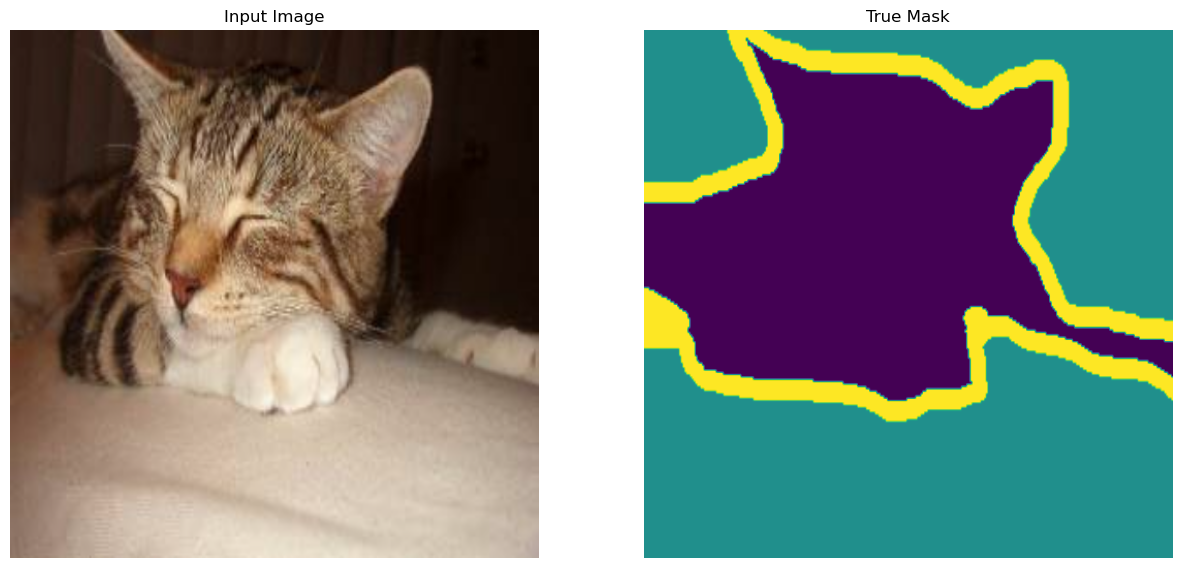

2023-04-16 17:01:39.510717: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


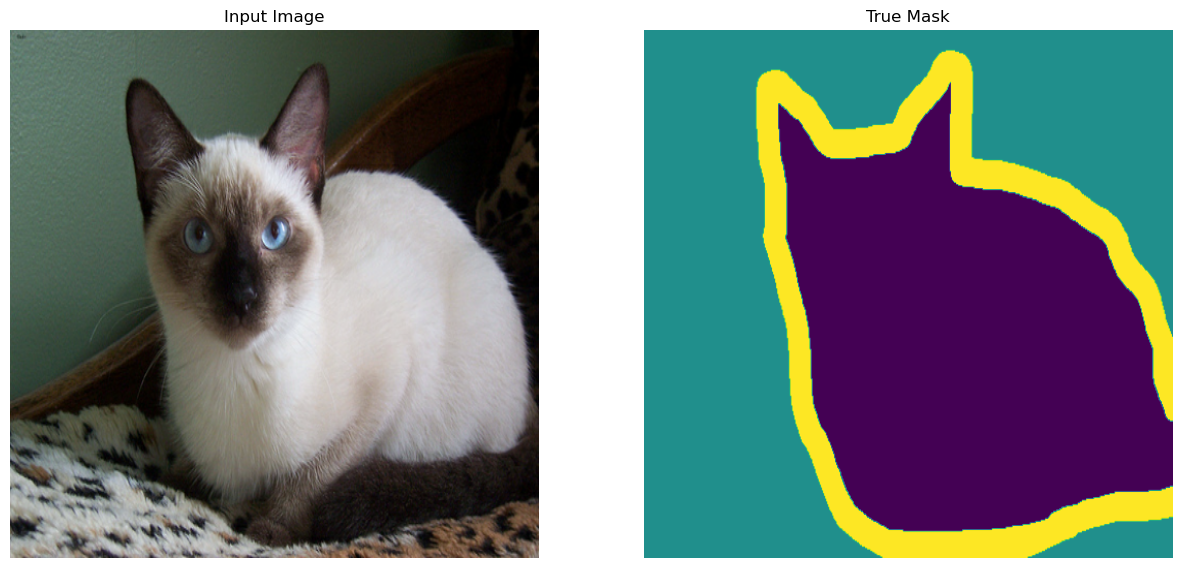

In [5]:
import matplotlib.pyplot as plt

def display(display_list): 
    plt.figure(figsize=(15, 15))
    
    title = ["Input Image", "True Mask", "Predicted Mask"]
    
    for i in range(len(display_list)): 
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis("off")
    plt.show()
    
for samples in train_ds.take(2): 
    sample_image, sample_mask = samples["pixel_values"][0], samples["labels"][0]
    sample_image = tf.transpose(sample_image, (1, 2, 0))
    sample_mask = tf.expand_dims(sample_mask, -1)
    display([sample_image, sample_mask])

In [6]:
from transformers import TFSegformerForSemanticSegmentation 

model_checkpoint = "nvidia/mit-b0"
id2label = {0: "outer", 1:"inner", 2:"border"}
label2id = {label: id for id, label in id2label.items()}
num_labels = len(id2label)
model = TFSegformerForSemanticSegmentation.from_pretrained(
    model_checkpoint, 
    num_labels=num_labels, 
    id2label=id2label, 
    label2id=label2id, 
    ignore_mismatched_sizes=True,)

2023-04-16 17:01:47.090016: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8401
2023-04-16 17:01:47.488514: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:219] failed to create cublas handle: cublas error
2023-04-16 17:01:47.488729: W tensorflow/core/kernels/conv_ops_gpu.cc:290] None of the algorithms provided by cuDNN frontend heuristics worked; trying fallback algorithms.  Conv: batch: 3
in_depths: 3
out_depths: 32
in: 518
in: 518
data_format: 1
filter: 7
filter: 7
filter: 3
dilation: 1
dilation: 1
stride: 4
stride: 4
padding: 0
padding: 0
dtype: DT_FLOAT
group_count: 1
device_identifier: "NVIDIA GeForce MX330 sm_6.1 with 2099904512B RAM and 3 cores"
version: 2

2023-04-16 17:01:47.513864: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:219] failed to create cublas handle: cublas error
2023-04-16 17:01:47.514058: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at conv_ops.cc:1152 : NOT_FOUND: No algorith

NotFoundError: Exception encountered when calling layer 'proj' (type Conv2D).

{{function_node __wrapped__Conv2D_device_/job:localhost/replica:0/task:0/device:GPU:0}} No algorithm worked!  Error messages:
  Profiling failure on CUDNN engine eng1{}: UNKNOWN: CUDNN_STATUS_ALLOC_FAILED
in tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc(4649): 'status'
  Profiling failure on CUDNN engine eng28{}: UNKNOWN: CUDNN_STATUS_ALLOC_FAILED
in tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc(4649): 'status'
  Profiling failure on CUDNN engine eng0{}: UNKNOWN: CUDNN_STATUS_ALLOC_FAILED
in tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc(4649): 'status'
  Profiling failure on CUDNN engine eng28{k2=1,k3=0}: UNKNOWN: CUDNN_STATUS_ALLOC_FAILED
in tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc(4649): 'status' [Op:Conv2D]

Call arguments received by layer 'proj' (type Conv2D):
  • inputs=tf.Tensor(shape=(3, 518, 518, 3), dtype=float32)